# Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
import tqdm
import cv2
from multiprocessing import Pool
WIDTH, HEIGHT= 1080, 1920
IMAGE_SIZE = 1920

u = dt.units


NameError: name 'IMG' is not defined

# Particle

In [2]:
def get_particle(z, r, center=False):
    if z is None:
        z = (np.random.random()*20 -10)
    if center:
        position = (IMAGE_SIZE//2),(IMAGE_SIZE//2),
    else:
        position = lambda: (20 + np.random.rand(2) * (IMAGE_SIZE - 40))
    return dt.MieSphere(
        refractive_index = 1.45, # SiO2
        position = position,
        radius = r,
        # position_unit="pixel",
        z = z*u.um,
        L=10,
        intensity=10,
        # offset_z=0
    )


# Single image

In [3]:
def get_image(wl, particle):
    optics = dt.Brightfield(NA=0.4,
                            wavelength=wl,
                            magnification=20,
                            output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
                            refractive_index_medium=1,
                            resolution = 14e-6,
                            padding=[64,64,64,64],
                            # upscale=1,
                            )
    single = optics(particle)
    return single

# def spectral_img(wls, particle):
#     particle_list = [get_image(wl, particle) for wl in wls]
#     data = sum(particle_list) / len(particle_list)
#     data.update()
#     return data

def spectral_img(wls, particle, NA=.7, mag=50):
    microscopes = [dt.Brightfield(NA=NA,
                                  wavelength=wl,
                                  magnification=mag,
                                  output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
                                  refractive_index_medium=1,
                                  resolution = 14e-6,
                                  # padding=[64,64,64,64],
                                  # upscale=1,
                                  )
                   for wl in wls]
    imgs = [microscope(particle) for microscope in microscopes]
    img = np.mean(imgs).resolve()
    return img / np.sum(img)


/home/npopkov/parsim/.venv/lib/python3.13/site-packages/deeptrack/optics.py:672: UserWarning: Likely bad optical parameters. NA / wavelength * 
                resolution / magnification = [0.65333333 0.65333333 0.65333333] should be at most 0.5. 
                To fix, set magnification to 2.0, and downsample
                the resulting image with 
                dt.AveragePooling((2.0, 2.0, 1))
                
  warnings.warn(
/home/npopkov/parsim/.venv/lib/python3.13/site-packages/deeptrack/optics.py:672: UserWarning: Likely bad optical parameters. NA / wavelength * 
                resolution / magnification = [0.56903226 0.56903226 0.56903226] should be at most 0.5. 
                To fix, set magnification to 2.0, and downsample
                the resulting image with 
                dt.AveragePooling((2.0, 2.0, 1))
                
  warnings.warn(
/home/npopkov/parsim/.venv/lib/python3.13/site-packages/deeptrack/optics.py:672: UserWarning: Likely bad optical parameters.

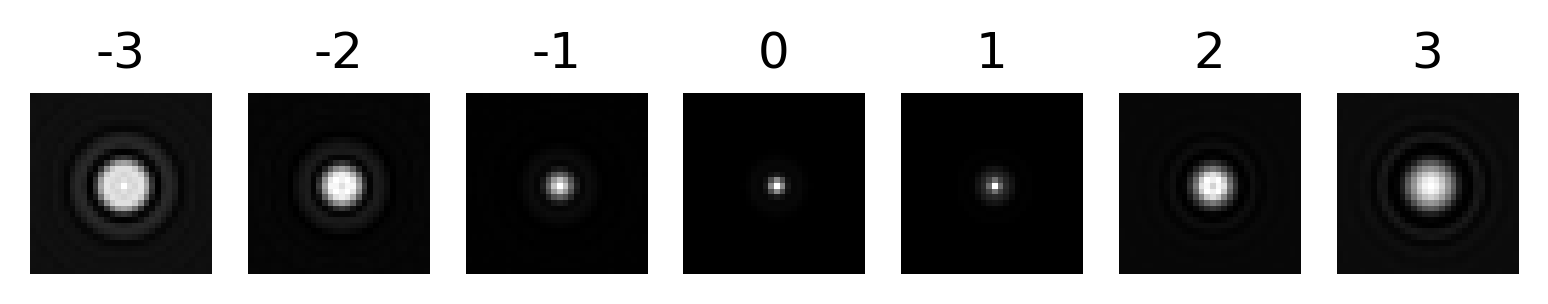

In [4]:
spectrum = np.linspace(300e-9,700e-9, 10)
fig, axes = plt.subplots(1,7,dpi=300)
zs = np.arange(-5,2)
for i,z in enumerate(zs):
    ax = axes.flatten()[i]
    particle = get_particle(z, r=1.4*1e-6, center=True)# dt.MieSphere(position=(IMAGE_SIZE/2, IMAGE_SIZE/2), z=z*u.um,  radius=1000e-9)
    img = spectral_img(spectrum, particle)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{z+2}")
    ax.axis("off")


  0%|          | 0/500 [00:00<?, ?it/s]/home/npopkov/parsim/.venv/lib/python3.13/site-packages/deeptrack/optics.py:672: UserWarning: Likely bad optical parameters. NA / wavelength * 
                resolution / magnification = [0.93333333 0.93333333 0.93333333] should be at most 0.5. 
                To fix, set magnification to 2.0, and downsample
                the resulting image with 
                dt.AveragePooling((2.0, 2.0, 1))
                
  warnings.warn(
/home/npopkov/parsim/.venv/lib/python3.13/site-packages/deeptrack/optics.py:672: UserWarning: Likely bad optical parameters. NA / wavelength * 
                resolution / magnification = [0.81290323 0.81290323 0.81290323] should be at most 0.5. 
                To fix, set magnification to 2.0, and downsample
                the resulting image with 
                dt.AveragePooling((2.0, 2.0, 1))
                
  warnings.warn(
/home/npopkov/parsim/.venv/lib/python3.13/site-packages/deeptrack/optics.py:672: User

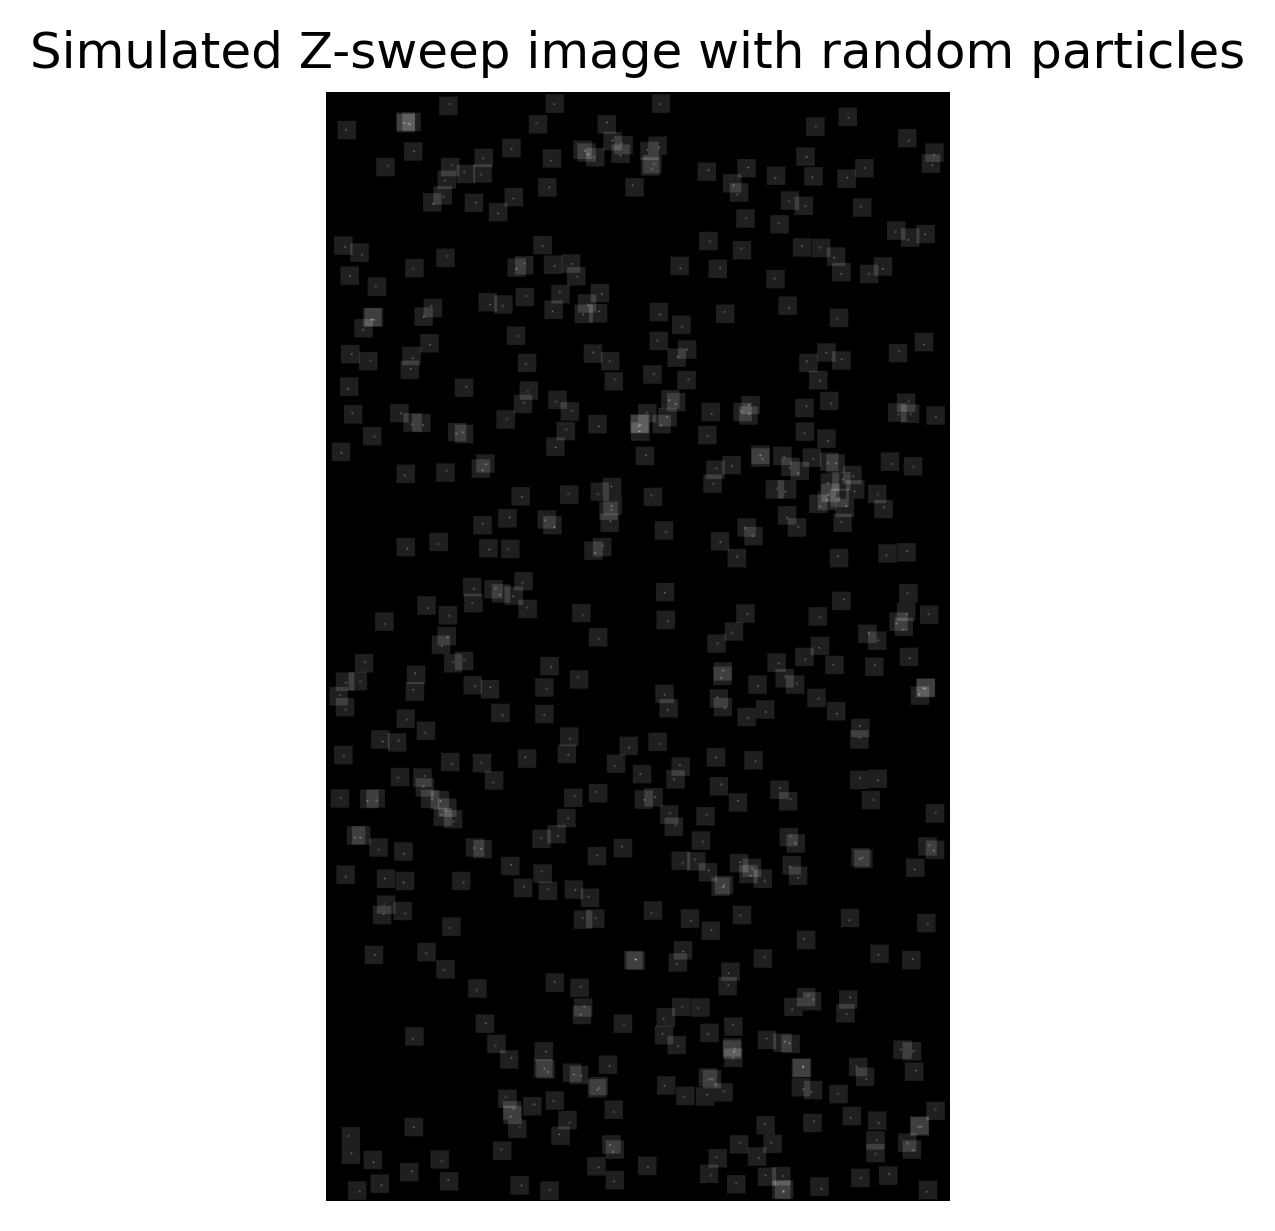

In [21]:
# create an image with WIDTH x HEIGHT pixels and spawn 500 particles randomly
canvas = np.zeros((HEIGHT, WIDTH,1))
for z in tqdm.tqdm(range(500)):
    particle = get_particle(z=None,r=1.4*1e-6, center=False)
    img = spectral_img(spectrum, particle, NA=0.4, mag=20)
    
    # find random position
    x = np.random.randint(0, WIDTH - IMAGE_SIZE)
    y = np.random.randint(0, HEIGHT - IMAGE_SIZE)
    # add the image to the canvas
    canvas[y:y+IMAGE_SIZE, x:x+IMAGE_SIZE,:] += img
    

#plot it
plt.figure(dpi=300)
plt.imshow(canvas, cmap="gray")
plt.axis("off")
plt.title("Simulated Z-sweep image with random particles")
plt.show()

tenengrad

In [5]:
def tenengrad(img, ksize=3):
    ''''TENG' algorithm (Krotkov86)'''
    Gx = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=ksize)
    Gy = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=ksize)
    FM = Gx*Gx + Gy*Gy
    mn = cv2.mean(FM)[0]
    if np.isnan(mn):
        return np.nanmean(FM)
    return mn


In [6]:
r = 1400*u.nm
zs = np.linspace(-10,10, 100)
wls = np.linspace(300e-9, 700e-9, 3)
imgs = [np.array(spectral_img(wls, get_particle(z, r, center=True))) for z in tqdm.tqdm(zs)]
imgs2 = [np.array(spectral_img(wls, get_particle(z,r, center=True), NA=.4, mag=50)) for z in tqdm.tqdm(zs)]
imgs3 = [np.array(spectral_img(wls, get_particle(z,r, center=True), NA=0.9)) for z in tqdm.tqdm(zs)]
tgs = np.array([tenengrad(img) for img in imgs])
tgs2 = np.array([tenengrad(img) for img in imgs2])
tgs3 = np.array([tenengrad(img) for img in imgs3])


  0%|          | 0/100 [00:00<?, ?it/s]/home/npopkov/parsim/.venv/lib/python3.13/site-packages/deeptrack/optics.py:672: UserWarning: Likely bad optical parameters. NA / wavelength * 
                resolution / magnification = [0.84 0.84 0.84] should be at most 0.5. 
                To fix, set magnification to 2.0, and downsample
                the resulting image with 
                dt.AveragePooling((2.0, 2.0, 1))
                
  warnings.warn(
100%|██████████| 100/100 [00:02<00:00, 45.80it/s]


<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_16868/2770947637.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("z_spp [$\mu m$]")


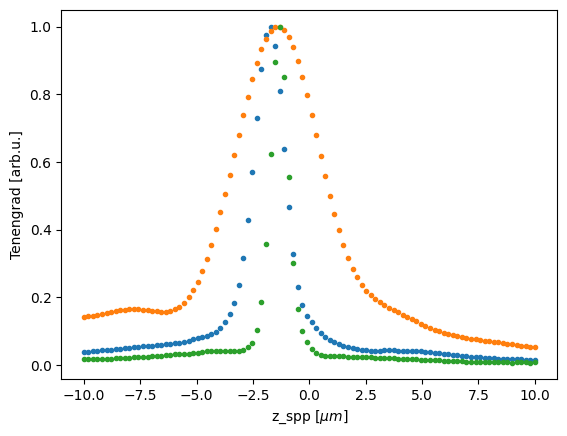

In [10]:
# np.save("tgs.npy", tgs)
# tgs = np.load("tgs.npy")
fig, ax = plt.subplots()
ax.plot(zs, tgs/max(tgs), ".")
ax.plot(zs, tgs2/max(tgs2), ".")
ax.plot(zs, tgs3/max(tgs3), ".")
ax.set_xlabel("z_spp [$\mu m$]")
ax.set_ylabel("Tenengrad [arb.u.]")
# print(zs[np.array(tgs).argmax()])

None


# High resolution plot

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_16868/2086158590.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("z$_\mathrm{particle}$ [$\mu m$]")


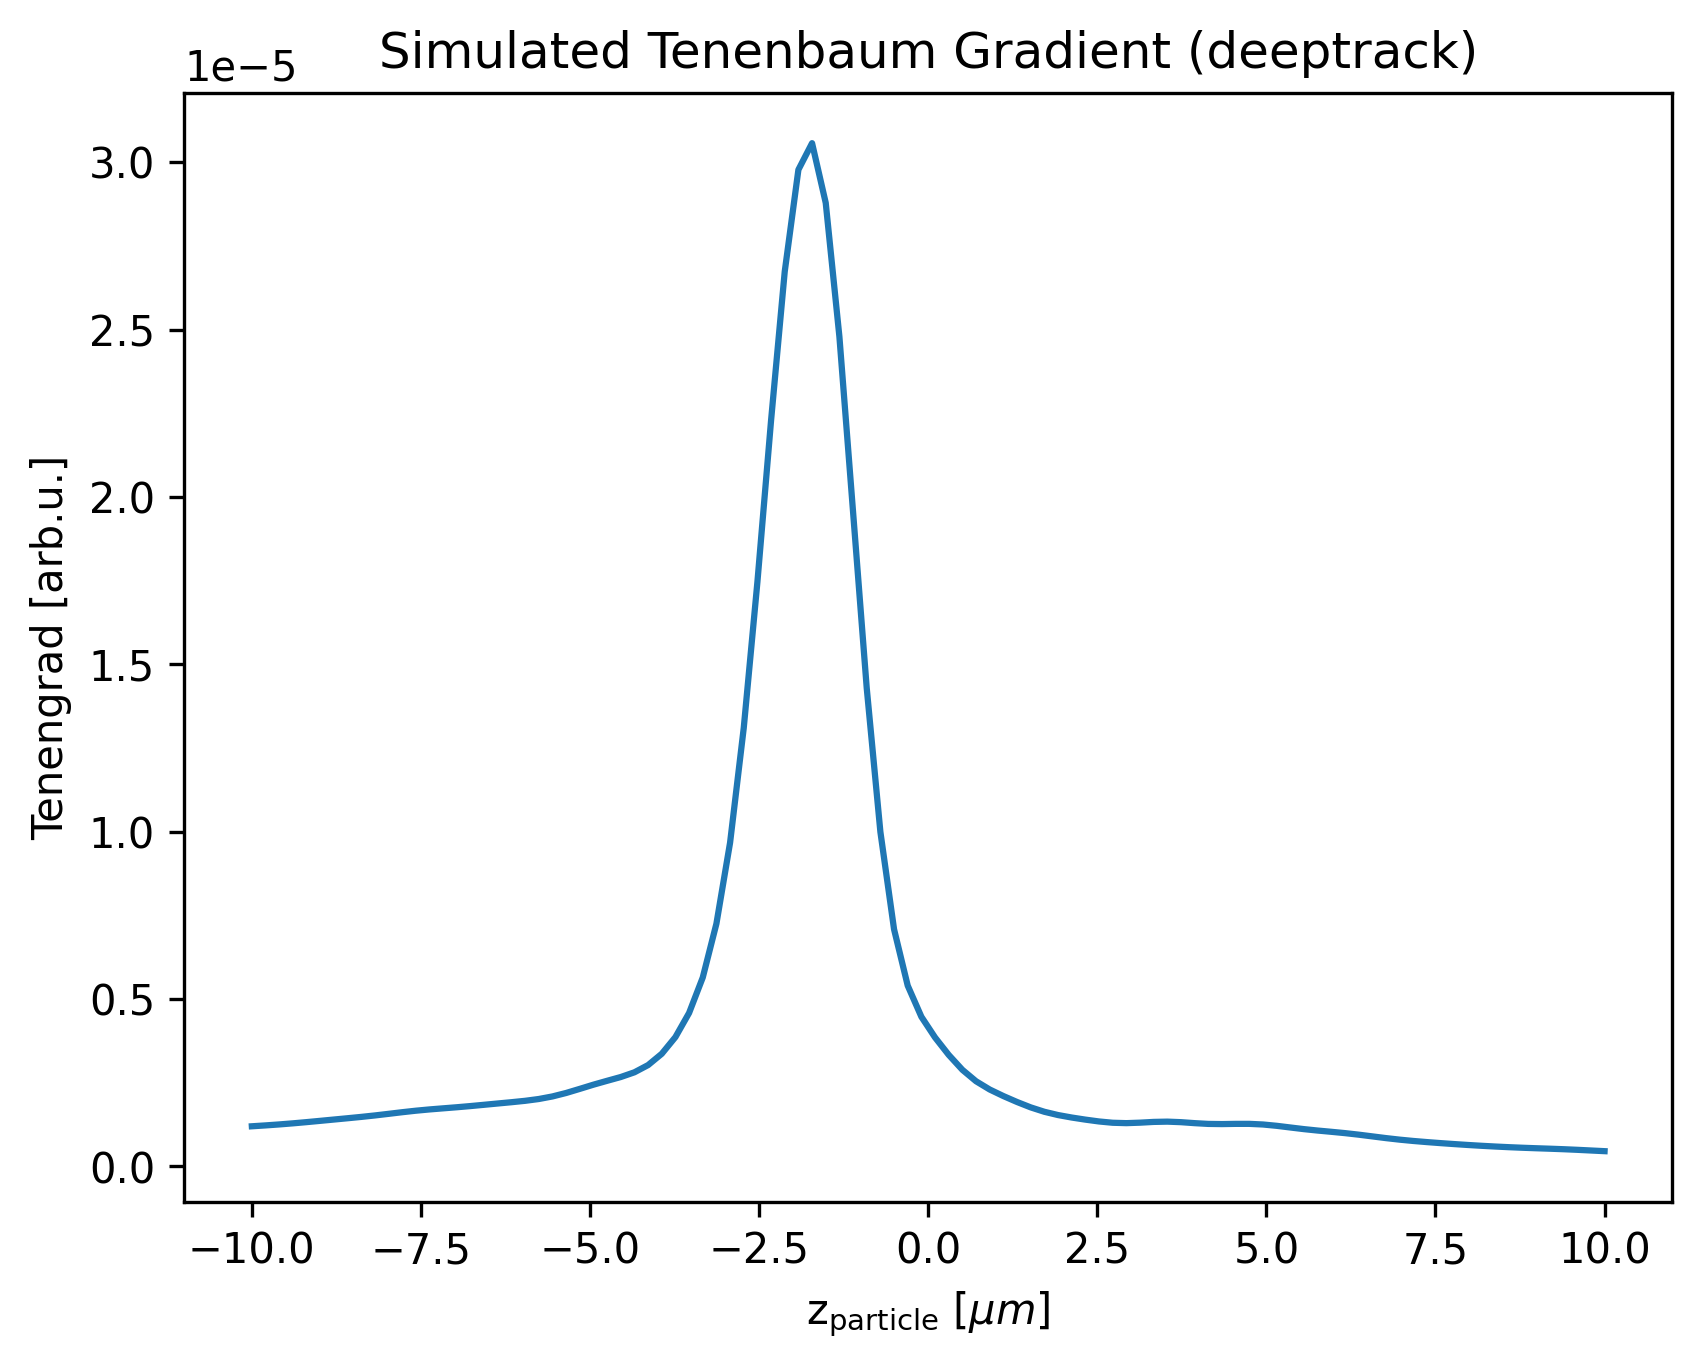

In [12]:
np.save("tgs.npy", tgs)
np.save("zs.npy", zs)
tgs_highres = np.load("tgs.npy")
zs_highres = np.load("zs.npy")
fig, ax = plt.subplots(dpi=300)
ax.plot(zs, tgs_highres)
ax.set_xlabel("z$_\mathrm{particle}$ [$\mu m$]")
ax.set_ylabel("Tenengrad [arb.u.]")
ax.set_title("Simulated Tenenbaum Gradient (deeptrack)")
None


In [13]:
print(tgs_highres.argmax())
print(zs[tgs_highres.argmax()])


41
-1.717171717171718
